# 1. Choosing which independent variables to use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

reg_15 = pd.read_csv('reg_2015.csv')
reg_15.dropna(inplace=True)

In [2]:
reg_15['Offensive_efficiency_avg5_diff'] = reg_15['Offensive_efficiency_avg5_home'] - reg_15['Offensive_efficiency_avg5_away']
reg_15['Defensive_efficiency_avg5_diff'] = reg_15['Defensive_efficiency_avg5_home'] - reg_15['Defensive_efficiency_avg5_away']
reg_15['win_avg5_diff'] = reg_15['win_avg5_home'] - reg_15['win_avg5_away']
reg_15['elo_diff'] = reg_15['elo_home'] - reg_15['elo_away']
reg_15['stad_diff'] = reg_15['home_over_overall'] - reg_15['away_over_overall']
reg_15['rate_diff'] = reg_15['home_rate'] - reg_15['away_rate'] 

### Checking for MultiCollinearity 

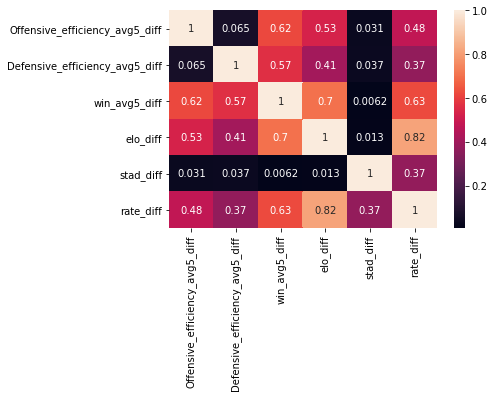

In [3]:
%matplotlib inline

corr_plot_2 = reg_15.iloc[:, 18:].corr()
sns.heatmap(abs(corr_plot_2), annot=True)

As we can see from the correlation plot, the feature "rate_diff" is highly correlated with the feature "elo_diff". Therefore, we will drop it to prevent any multicollinearity issues.

In [4]:
reg_15 = reg_15.drop(columns = ['rate_diff'])
features = reg_15.columns[18:]

No remaining variables are highly correlated ( >> 0.7)

# 2. Train/Test Split

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = reg_15.iloc[:, 18:].values
y = reg_15.iloc[:, 5].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 3. Models

## 3.0 Baseline Model

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [7]:
np.random.seed(0)
y_baseline = np.random.randint(2, size=(288,))
cm_base = confusion_matrix(y_test, y_baseline)
print(cm_base)
accuracy_score(y_test, y_baseline)

[[54 56]
 [89 89]]


0.4965277777777778

In [8]:
def confusion_heatmap(cm, percentage=False):
    if percentage:
        sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
    else: 
        sns.heatmap(cm, annot=True)

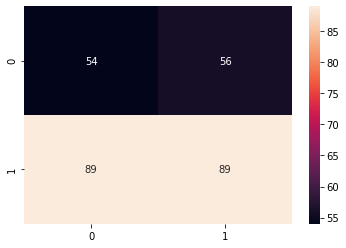

In [9]:
confusion_heatmap(cm_base, False)

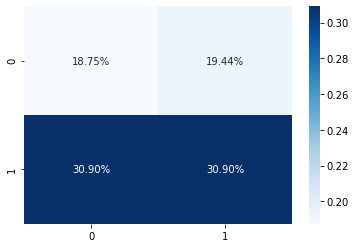

In [10]:
confusion_heatmap(cm_base,True)

## 3.1 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [13]:
cm_lr = confusion_matrix(y_test, y_pred)
print(cm_lr)
accuracy_score(y_test, y_pred)

[[ 63  47]
 [ 34 144]]


0.71875

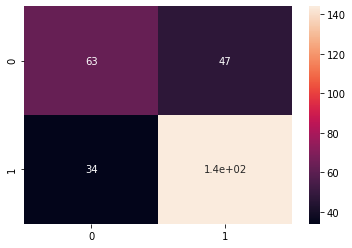

In [14]:
confusion_heatmap(cm_lr, False)

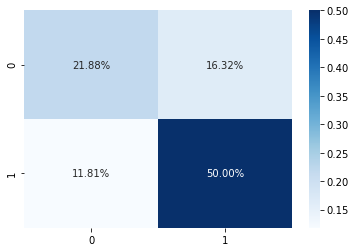

In [15]:
confusion_heatmap(cm_lr, True)

### K-Fold Cross Validation 

In [16]:
from sklearn.model_selection import cross_val_score

def cross_val_result(est):
    
    accuracies = cross_val_score(estimator = est, X = X_train, y = y_train, cv = 15)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
    
cross_val_result(lr)

Accuracy: 67.58 %
Standard Deviation: 6.21 %


### Hyperparameter Tuning using GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]} # l1 lasso l2 ridge
logreg=LogisticRegression()

def gridsearch_result(model, grid):
    model_cv = GridSearchCV(model,grid,cv=15)
    model_cv.fit(X_train,y_train)
    
    print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
    print("accuracy :",model_cv.best_score_)
    
    return model_cv.best_score_
    
logreg_score = gridsearch_result(logreg,grid)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.679270014115749


Feature: 0, Score: 0.28649
Feature: 1, Score: -0.34503
Feature: 2, Score: -0.44382
Feature: 3, Score: 0.84547
Feature: 4, Score: -0.03389


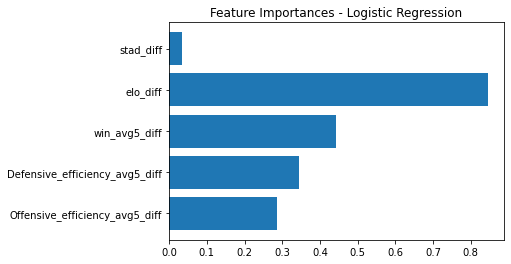

In [18]:
# get optimized model
lr = LogisticRegression(C = 0.1, penalty = 'l2')
lr.fit(X_train, y_train)

# get importance
lr_importance = lr.coef_[0]

def plot_feature_importance(importance, title):
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.title("Feature Importances - " + title)
    plt.barh([features[x] for x in range(len(importance))], abs(importance))
    plt.show()
    
plot_feature_importance(lr_importance, "Logistic Regression")

## 3.2 Random Forest 

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [20]:
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)
accuracy_score(y_test, y_pred)

[[ 70  40]
 [ 45 133]]


0.7048611111111112

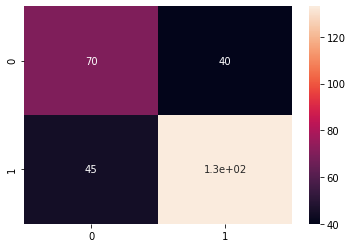

In [21]:
confusion_heatmap(cm_rf,False)

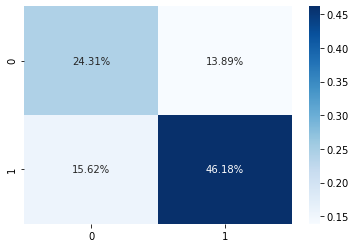

In [22]:
confusion_heatmap(cm_rf,True)

### K-Fold Cross Validation 

In [23]:
cross_val_result(rf)

Accuracy: 64.10 %
Standard Deviation: 5.80 %


### Hyperparameter Tuning using GridSearchCV

In [24]:
grid={'bootstrap': [True, False],
 'max_depth': [10, 50, 100],
 'n_estimators': [10, 100, 500]}

randf=RandomForestClassifier()

randf_score = gridsearch_result(randf,grid)

tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': 10, 'n_estimators': 100}
accuracy : 0.6572091147408752


Feature: 0, Score: 0.20007
Feature: 1, Score: 0.20272
Feature: 2, Score: 0.08496
Feature: 3, Score: 0.33241
Feature: 4, Score: 0.17985


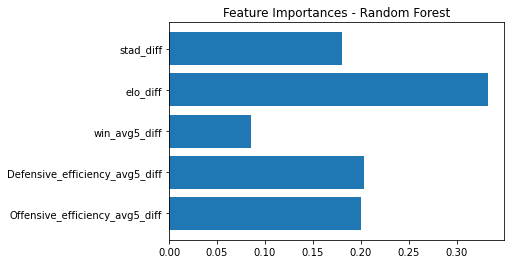

In [25]:
# get optimized model
rf = RandomForestClassifier(bootstrap=True, max_depth=10, n_estimators=100)
rf.fit(X_train,y_train)

# get importance
rf_importance = rf.feature_importances_

plot_feature_importance(rf_importance, "Random Forest")

## 3.3 Neural Network

In [26]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(50,), max_iter = 1000, random_state=0)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

In [27]:
cm_nn = confusion_matrix(y_test, y_pred)
print(cm_nn)
accuracy_score(y_test, y_pred)

[[ 63  47]
 [ 44 134]]


0.6840277777777778

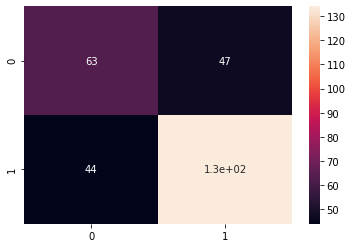

In [28]:
confusion_heatmap(cm_nn, False)

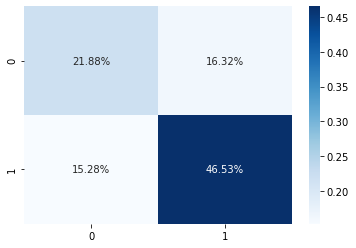

In [29]:
confusion_heatmap(cm_nn, True)

### K-Fold Cross Validation 

In [30]:
cross_val_result(nn)

Accuracy: 68.04 %
Standard Deviation: 5.90 %


### Hyperparameter Tuning using GridSearchCV

In [31]:
grid={
    'activation': ('tanh','relu'),
    'hidden_layer_sizes': ((10,),(50,),(100,)),
    'max_iter': (1000, 1500)
}

nnet=MLPClassifier()

nnet_score = gridsearch_result(nnet,grid)

tuned hpyerparameters :(best parameters)  {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 1500}
accuracy : 0.683887880621093


## 3.4 Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [33]:
cm_nb = confusion_matrix(y_test, y_pred)
print(cm_nb)
accuracy_score(y_test, y_pred)

[[ 75  35]
 [ 44 134]]


0.7256944444444444

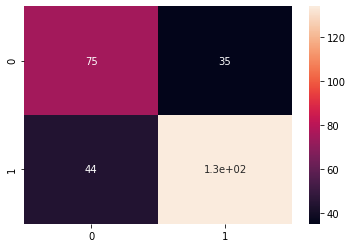

In [34]:
confusion_heatmap(cm_nb,False)

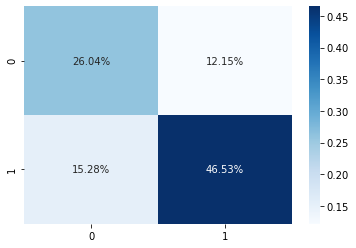

In [35]:
confusion_heatmap(cm_nb,True)

### K-Fold Cross Validation

In [36]:
cross_val_result(nb)

Accuracy: 64.10 %
Standard Deviation: 8.12 %


### Hyperparameter Tuning using GridSearchCV

In [37]:
grid={
    'var_smoothing': (1e-6,1e-9,1e-12)
}

nbayes=GaussianNB()
nbayes_score = gridsearch_result(nbayes,grid)

tuned hpyerparameters :(best parameters)  {'var_smoothing': 1e-06}
accuracy : 0.641016333938294


## 3.5 Support Vector Machine

In [38]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', random_state = 0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [39]:
cm_svc = confusion_matrix(y_test, y_pred)
print(cm_svc)
accuracy_score(y_test, y_pred)

[[ 57  53]
 [ 23 155]]


0.7361111111111112

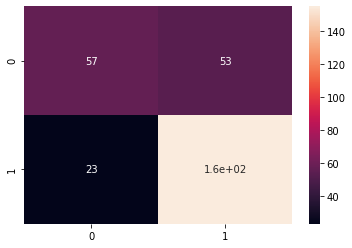

In [40]:
confusion_heatmap(cm_svc,False)

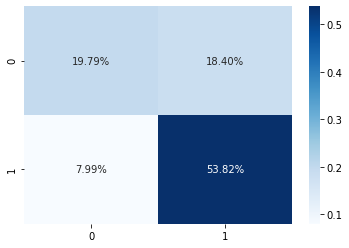

In [41]:
confusion_heatmap(cm_svc,True)

### K-Fold Cross Validation

In [42]:
cross_val_result(svc)

Accuracy: 66.88 %
Standard Deviation: 5.67 %


### Hyperparameter Tuning using GridSearchCV

In [43]:
grid=[
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

svm=SVC()
svm_score = gridsearch_result(svm,grid)

tuned hpyerparameters :(best parameters)  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy : 0.6745311554748942


Feature: 0, Score: 0.27252
Feature: 1, Score: -0.37148
Feature: 2, Score: -0.57292
Feature: 3, Score: 1.00515
Feature: 4, Score: -0.11324


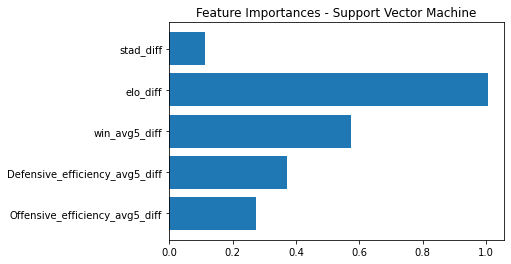

In [44]:
# get importance
svc_importance = svc.coef_[0]

plot_feature_importance(svc_importance, "Support Vector Machine")

# 4. Conclusion

In [45]:
print("Accuracies:")
print()
print("Logistic Regression: %1.2f"%(logreg_score))
print("Random Forest: %1.2f"%(randf_score))
print("Neural Network: %1.2f"%(nnet_score))
print("Naive Bayes: %1.2f"%(nbayes_score))
print("Support Vector Machine: %1.2f"%(svm_score))


Accuracies:

Logistic Regression: 0.68
Random Forest: 0.66
Neural Network: 0.68
Naive Bayes: 0.64
Support Vector Machine: 0.67


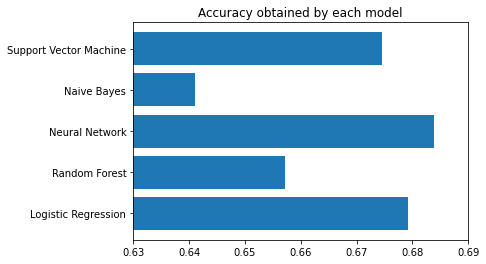

In [46]:
models = ['Logistic Regression', 'Random Forest', 'Neural Network', 'Naive Bayes', 'Support Vector Machine']
scores = [logreg_score, randf_score, nnet_score, nbayes_score, svm_score]

plt.title("Accuracy obtained by each model")
plt.barh(models, scores)
plt.xlim(0.63,0.69)
plt.show()